#[TI] 02 - Génération aléatoire d'ellipses

Compléter la fonction ```void randomEllipses(const int n)``` de la classe ```Image``` pour générer ```n``` ellipses de façon aléatoire. 

Chaque ellipse sera affectée d'un label compris entre 0 et ```n - 1```. On veillera à ce que la dimension des ellipses générées soit raisonnable relativement aux dimensions de l'image.

In [49]:
%%writefile image.h

#ifndef __Image_h
#define __Image_h

#include <cmath>
#include <iostream>
#include <vector>
#include <limits>
#include <fstream>
#include <string>
#include <sstream>
#include <functional>
#include <algorithm>
#include <ctime>

namespace v2_0
{
    const double pi{ std::acos(-1.0) };

    template <typename T>
    class Image
    {
        using image_type = std::vector< std::vector< T > >;

    protected:
        image_type m_pixels;
        std::size_t m_width, m_height;

    public:
        Image(std::size_t width = 0, std::size_t height = 0);

        T& operator()(int i, int j) { return m_pixels[i][j]; }
        const T& operator()(int i, int j) const { return m_pixels[i][j]; }

        int getWidth() { return m_width; }
        int getWidth() const { return m_width; }
        int getHeight() { return m_height; }
        int getHeight() const { return m_height; }

        void white();
        void sinus(int n = 1);
        void checkerboard(int nx, int ny);
        void fill(const std::function<double(int,int)>& f);
        void fillWith(const std::vector<double>& v);
        void randomEllipses(const int n);

        template<typename U>
        Image<U> convert(bool rescale = false);

        bool read(const std::string& fileName, bool littleEndian = true);
        void write(const std::string& fileName);
    };

    template<typename T>
    Image<T>::Image(std::size_t width, std::size_t height)
        : m_width(width), m_height(height)
    {
        m_pixels = image_type(width);
        for (std::size_t i{ 0 }; i < width; ++i)
            m_pixels[i] = std::vector<T>(height);
    }

    template<typename T>
    void Image<T>::white()
    {
        for (std::size_t i{ 0 }; i < m_width; ++i)
            for (std::size_t j{ 0 }; j < m_height; ++j)
                m_pixels[i][j] = std::numeric_limits<T>::max();
    }

    template<typename T>
    void Image<T>::sinus(int n)
    {
        for (std::size_t i{ 0 }; i < m_width; ++i)
        {
            T value{ static_cast<T>(std::sin(2 * pi * n * i / (m_width - 1))) };
            for (std::size_t j{ 0 }; j < m_height; ++j)
                m_pixels[i][j] = value;
        }
    }

    template<typename T>
    void Image<T>::checkerboard(int nx, int ny)
    {
        auto minOut{ std::numeric_limits<T>::min() }, maxOut{ std::numeric_limits<T>::max() };
        auto sizeX{ m_width / nx }, sizeY{ m_height / ny };
        for (std::size_t i{}; i < m_width; ++i)
        {
            auto cellX{ i / sizeX };
            for (std::size_t j{}; j < m_height; ++j)
            {
                auto cellY{ j / sizeY };
                m_pixels[i][j] = ((cellX % 2 == 0 && cellY % 2 == 0)
                            || (cellX % 2 != 0 && cellY % 2 != 0))
                            ? maxOut : minOut;
            }
        }
    }

    template<typename T>
    void Image<T>::fill(const std::function<double(int,int)>& f)
    {
        const auto nx{ m_width / 2 }, ny{ m_height / 2 };
        for (std::size_t i{}; i < m_width; ++i)
            for (std::size_t j{}; j < m_height; ++j)
                m_pixels[i][j] = static_cast<T>(f(i - nx, j - ny));
    }

    template<typename T>
    void Image<T>::fillWith(const std::vector<double>& v)
    {
        int k{ 0 };
        for (int x{ 0 }; x < m_width; ++x)
            for (int y{ 0 }; y < m_height; ++y)
                m_pixels[x][y] = static_cast<T>(v[k++]);
    }

    /*****************************
      RANDOM ELLIPSE BEGIN
    *****************************/

  template<typename T>
  void Image<T>::randomEllipses(const int n)
  {
    srand(time(nullptr));

    long unsigned int dimensionMax {(m_width <= m_height ? m_width:m_height)/2};
    long unsigned int dimensionMin {10 <= dimensionMax/10 ? 10 : dimensionMax/10};

    
    for (int i {0}; i < n; ++i)
    {   
        long unsigned int x{0}, y{0}, z{0}, q{0};
        x = rand() % m_width;
        y = rand() % m_height;

        z = rand() % (dimensionMax - dimensionMin) + dimensionMin;
        q = rand() % (dimensionMax - dimensionMin) + dimensionMin;
       
        int label{i};
        long unsigned int u_start{0}, u_end{0},  v_start{0}, v_end{0};
        
        if ((x + z) <= m_width)
          u_end = (x + z);
        if ((x - z) > 0)
          u_start = x - z;
        else
          u_end = m_width;

        if ((y + q) <= m_height)
          v_end = (y + q);
        else
            v_end = m_height;

        if ((y - q) > 0)
          v_start = y - q;
        else
          v_start = 0;
        

        for (long unsigned int u{u_start}; u < u_end; ++u)
          for (long unsigned int v {v_start}; v < v_end ; ++v)
          {
            if (((u - x) * (u - x)) * (q * q) + ((v - y) * (v - y)) * (z * z) <= (z * z) * (q * q))
              (*this)(u, v) = label;
          }
      }
    }

    /*****************************
      RANDOM ELLIPSE END
    *****************************/

    // T type de codage de l'image d'entrée, U type de codage de l'image de sortie
    // Ajustement de dynamique possible si rescale = true
    template<typename T>
    template<typename U>
    Image<U> Image<T>::convert(bool rescale)
    {
        Image<U> imageOut(m_width, m_height);

        // Adjust output range to input range
        if (rescale)
        {
            // Compute minimum and maximum input gray levels
            auto inMin{ m_pixels[0][0] }, inMax{ inMin };
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                {
                    if (m_pixels[i][j] > inMax)
                        inMax = m_pixels[i][j];
                    else if (m_pixels[i][j] < inMin)
                        inMin = m_pixels[i][j];
                }

            auto outMin{ std::numeric_limits<U>::min() };
            auto outMax{ std::numeric_limits<U>::max() };
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                    imageOut(i, j) = static_cast<U>(outMin
                        + (outMax - outMin) * (m_pixels[i][j] - inMin) / static_cast<double>(inMax - inMin));
        }
        else
        {
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                    imageOut(i, j) = static_cast<U>(m_pixels[i][j]);
        }
        
        return imageOut;
    }

    // Swap byte order
    template <typename T>
    void endswap(T *objp)
    {
        unsigned char *memp = reinterpret_cast<unsigned char*>(objp);
        std::reverse(memp, memp + sizeof(T));
    }

    // T type de codage du fichier
    template<typename T>
    bool Image<T>::read(const std::string& fileName, bool littleEndian)
    {
        std::ifstream fIn(fileName, std::ios::in | std::ios::binary);
        if (!fIn.is_open())
        {
            std::cerr << "Can't open " << fileName << '\n';
            return false;
        }
 
        for (std::size_t j{}; j < m_height; ++j)
            for (std::size_t i{}; i < m_width; ++i)
            {
                T value{};
                fIn.read( reinterpret_cast<char*>(&value), sizeof(T) );
                if (littleEndian) endswap(&value);
                m_pixels[i][j] = value;
            }

        fIn.close();

        return true;
    }

    template<typename T>
    void Image<T>::write(const std::string& fileName)
    {
        std::ofstream fOut(fileName, std::ios::out | std::ios::binary);
        if (!fOut.is_open())
        {
            std::cerr << "Can't open " << fileName << '\n';
            return;
        }
        
        for (std::size_t j{}; j < m_height; ++j)
            for (std::size_t i{}; i < m_width; ++i)
                fOut.write( reinterpret_cast<char*>(&m_pixels[i][j]), sizeof(T));

        fOut.close();
    }
	
    template <typename T>
    class RGB 
    {
    public:
        T R, G, B;
        T& operator[](int i) { 
            if (i == 0) return R;
            else if (i == 1) return G;
            else return B;
        }
        const T& operator[](int i) const { 
            if (i == 0) return R;
            else if (i == 1) return G;
            else return B;
        }
        const int size() { return 3; }
    };

	template <typename T>
    class ImageRGB : public Image<RGB<T>>
    {
    public:
        ImageRGB(int width = 0, int height = 0) : Image<RGB<T>>(width, height) {}
        ImageRGB(const Image<T>& image, const std::string& lutName, bool binary = true);
    };
	
    template<typename T>
    ImageRGB<T>::ImageRGB(const Image<T>& image, const std::string& lutName, bool binary)
        : Image<RGB<T>>(image.getWidth(), image.getHeight())
    {
        const auto numGrayLevel{ static_cast<std::size_t>(std::pow(256, sizeof(T))) };
        std::vector<RGB<T>> lut(numGrayLevel);

        if (binary)
        {
            std::ifstream file(lutName, std::ios::binary);
            if (!file.is_open())
            {
                std::cerr << "Can't open binary LUT file " << lutName << '\n';
                return;
            }

            file.seekg(32, std::ios::cur); // 32 bytes offset from current position
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].R), sizeof(T));
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].G), sizeof(T));
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].B), sizeof(T));
            file.close();
        }
		else
        {
            std::ifstream file(lutName);
            if (!file.is_open())
            {
                std::cerr << "Can't open text LUT file " << lutName << '\n';
                return;
            }
            std::string line;
            std::getline(file, line);
            for (std::size_t i{}; i < numGrayLevel; ++i)
            {
                std::getline(file, line);
                std::istringstream iss(line);
                std::string item;
                std::getline(iss, item, '\t');
                std::getline(iss, item, '\t');
                lut[i].R = static_cast<T>(std::stoi(item));
                std::getline(iss, item, '\t');
                lut[i].G = static_cast<T>(std::stoi(item));
                std::getline(iss, item, '\t');
                lut[i].B = static_cast<T>(std::stoi(item));
            }
            file.close();
        }

        for (std::size_t i{ 0 }; i < this->m_width; ++i)
            for (std::size_t j{ 0 }; j < this->m_height; ++j)
            {
                const auto index{ static_cast<std::size_t>(image(i,j)) };
                this->m_pixels[i][j] = lut[index];
            }
    }
}

#endif

Overwriting image.h


In [50]:
%%writefile tecSanLib.cpp

#include <iostream>
#include "image.h"

int main()
{
    using pixel_type = double;
    using output_file_type = unsigned char;

    constexpr int width{ 512 }, height{ 512 };

	  // Create a new pixel_type image
    v2_0::Image<pixel_type> img(width, height);

    // Generate 5 random randomEllipses
    const auto nEllipses{ 5 };
    img.randomEllipses(nEllipses);

    // Write image to raw file (rescaling because type narrowing)
    auto imgOut{ img.convert<output_file_type>(true) };
    imgOut.write("ellipses.raw");

    // Convert to RGB image using binary LUT
    v2_0::ImageRGB<output_file_type> imgRGB(imgOut, "Random.lut", false);
    imgRGB.write("ellipsesRGB.raw");

    return 0;
}

Overwriting tecSanLib.cpp


In [51]:
# Generate a random LUT
from random import randrange
with open('Random.lut', 'w') as f:
  f.write("\tR\tG\tB\n")
  for i in range(256):
    f.write("\t{}\t{}\t{}\n".format(randrange(256), randrange(256), randrange(256)))

In [52]:
%%shell
g++ tecSanLib.cpp -o output
./output

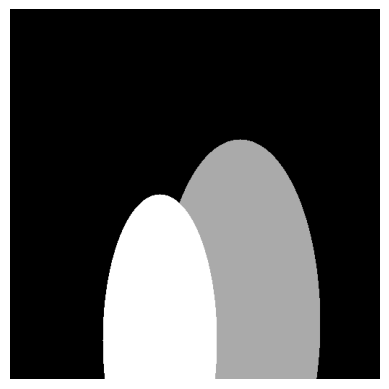

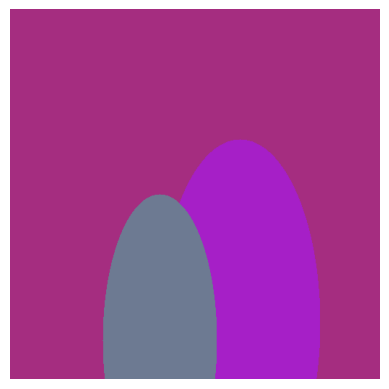

In [53]:
from matplotlib import pyplot as plt
import numpy as np

gray_level_file = 'ellipses.raw'
img = np.fromfile(gray_level_file, dtype=np.uint8)
imageSize = (512, 512)
img = img.reshape(imageSize)

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

!pip install -U -q rawpy
import rawpy

color_file = 'ellipsesRGB.raw'
img = np.fromfile(color_file, dtype=np.uint8)
np.shape(img)
imageSize = (512, 512, 3)
img = np.reshape(img, imageSize)

plt.imshow(img)
plt.axis("off")
plt.show()